# Import data
Imports data as numpy array (nr_of_sequences, 16, 128, 128, 3)

In [1]:
from load_dataset_numpy import load_dataset_numpy

sequence_limit = 15
X_train, Y_train, X_train_flow_paths, X_train_warped_paths, X_train_diff_paths, X_test, Y_test, X_test_flow_paths, X_test_warped_paths, X_test_diff_paths, image_count = load_dataset_numpy(difficulty="All", sequence_limit = sequence_limit + 1)

Using TensorFlow backend.


processing folder 0, number of images in that folder 16 
total cumulative number of image sequences:  1
processing folder 1, number of images in that folder 299 
total cumulative number of image sequences:  285
processing folder 2, number of images in that folder 44 
total cumulative number of image sequences:  314
processing folder 3, number of images in that folder 50 
total cumulative number of image sequences:  349


In [3]:
print('output shape {}'.format(X_train.shape))
print('number of sequences {}'.format(X_train.shape[0]))

output shape (349, 16, 128, 128, 3)
number of sequences 349


# Layer structure

<img src="images/layer_structure.png">

### Important: if target is categorical use Dense(8) if target is binary use Dense(3)

In [1]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Conv2D, Dense, LSTM,MaxPooling2D , Flatten, TimeDistributed,Activation

im_size = 227
time_steps = 16 # len of image sequence
channels = 3
#input_shape=(5, 128, 128, 3)))

model = Sequential()
model.add(TimeDistributed(Conv2D(filters=96, kernel_size=7,  strides=2, padding='valid'), input_shape=(time_steps,im_size,im_size,channels))) # first input shape is the len of seq
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Conv2D(filters=384, kernel_size=3,  strides=2, padding='valid')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Conv2D(filters=512, kernel_size=3, padding='same')))
model.add(TimeDistributed(Conv2D(filters=512, kernel_size=3, padding='same')))
model.add(TimeDistributed(Conv2D(filters=384, kernel_size=3, padding='same')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Flatten())) #The Flatten layer is only needed because LSTM shape should have one dimension per input.
model.add(TimeDistributed(Dense(4096)))
model.add(LSTM(256, return_sequences=False)) #pole kindel return_sequence's, kui True, siis multiple outputs
#When return_sequences=True, the output shape is (batch, timeSteps, outputFeatures)
#When return_sequences=False, the output shape is (batch, outputFeatures)
model.add((Dense(3))) # for categorical use Dense(8), for binary use Dense(3)
model.add((Activation('softmax')))
print(model.summary())

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 16, 111, 111, 96)  14208     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 55, 55, 96)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 27, 27, 384)   332160    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 13, 13, 384)   0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 13, 13, 512)   1769984   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 13, 13, 512)   2359808   
_________________________________________________________________
time_distributed_7 (TimeDist (None, 16, 13, 13, 384)  

## Categorical labels

In [2]:
#Encoding the labels
from sklearn.preprocessing import LabelBinarizer
labels = set(['BOO', 'BLO', 'BOR', 'BLR', 'OLR', 'OLO', 'OOR', 'OOO'])
print(labels)
lb = LabelBinarizer()
lb.fit(list(labels))
print('categorical labels: \n', lb.transform(['BOO', 'BLO', 'BOR', 'BLR', 'OLR', 'OLO', 'OOR', 'OOO']))

{'BLO', 'OOR', 'BLR', 'OOO', 'BOO', 'OLR', 'BOR', 'OLO'}
categorical labels: 
 [[0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0]]


## Binary labels

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=['B','L','R'])

def labels_to_binary(ini_labels):
    """
    Takes as input list of labels (e.g. ['BOO', 'BLO', 'BOR'])
    Outputs numpy ndarray of the labels in binary (e.g. [[1 0 0] [1 1 0] [1 0 1])
    """
    labels = []
    for label in ini_labels:
        label_split = list(label) # ['BLO'] -> ['B','L','O']
        labels.append(label_split) # [['B','L','O']]

    return mlb.fit_transform(labels)


ini_labels = ['BOO', 'BLO', 'BOR', 'BLR', 'OLR', 'OLO', 'OOR', 'OOO']
print('initial labels: \n', ini_labels)
labels_binary = labels_to_binary(ini_labels)
print('labels in binary: \n', labels_binary)

initial labels: 
 ['BOO', 'BLO', 'BOR', 'BLR', 'OLR', 'OLO', 'OOR', 'OOO']
labels in binary: 
 [[1 0 0]
 [1 1 0]
 [1 0 1]
 [1 1 1]
 [0 1 1]
 [0 1 0]
 [0 0 1]
 [0 0 0]]


/home/anneott/miniconda3/envs/stacc/lib/python3.6/site-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))


## Fit generator
Kommentaar: parameetri "aug" kasutus pole hetkel implementeeritud

Source:https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

In [8]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.preprocessing.image import load_img,img_to_array
from load_dataset_numpy import window


# label_type: "binary" or "categorical"
def png_image_generator(path, bs, mode="train",difficulty="All", sequence_limit=16, resize_dimension = 227, label_type = "categorical", aug=None):    
    f = open("{0}/{1}.txt".format(path, difficulty))

    # loop indefinitely
    while True:
        # initialize our batches of images
        image_count = 0
        X_train = []
        X_test = []
        Y_train = []
        Y_test = []
        X_train_flow_paths = []
        X_test_flow_paths = []
        X_train_warped_paths = []
        X_test_warped_paths = []
        X_train_diff_paths = []
        X_test_diff_paths = []

        folder_count = 0
        
        content = f.readlines()
        for folder in content:
            # Load the data
            folder_components = folder.split("_")
            folder_components[-1] = folder_components[-1][:-1]
            base = str("_".join(folder_components[:-2]))
            folder = "{0}/{1}/{2}".format(path, base, (base + "_" + str(folder_components[-2])))
            folder += "/" + (str("_".join(folder_components)))
            try:
                os.makedirs(folder+"/flow_fields")
            except: 
                pass
            try:
                os.makedirs(folder+"/warped")
            except:
                pass
            try:
                os.makedirs(folder+"/difference")
            except:
                pass
            folder += "/light_mask"
            images = [folder + "/" + f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
            image_count += len(images)
            img_list = [] #np.empty((16, 128,128,3)) # images from all the sequences

            flow_path_list = []
            warped_path_list = []
            diff_path_list = []
            im_seq_count = 0
            print('\n processing folder {0}, number of images in that folder {1} '.format(folder_count,len(images)))

            # split the images into sequneces of length 16
            #(e.g. folder contains 20 images, then first seq is 1-16, second seq 2-17, third seq 3-18 etc)
            for each in window(images, 16):
                img_seq_list = [] # only images from one 16 image sequence,  size will be (16, 128,128,3)
                one_images_seq = np.array(each) # 1-16, 2-17, etc

                # read each image to numpy sequence
                for img in one_images_seq:
                    img_load = load_img(img, target_size = (resize_dimension,resize_dimension))
                    img_array = img_to_array(img_load)
                    img_seq_list.append(img_array)

                    flow_path_list.append(img.replace('/light_mask','/flow_fields'))
                    warped_path_list.append(img.replace('/light_mask','warped'))
                    diff_path_list.append(img.replace('light_mask','difference'))

                if("test-" in folder):
                    X_test.append(np.asarray(img_seq_list))
                    Y_test.append(folder_components[-2])     
                    X_test_flow_paths.append(flow_path_list)
                    X_test_warped_paths.append(warped_path_list)
                    X_test_diff_paths.append(diff_path_list)
                    if (len(X_test) == bs):
                        if label_type == "categorical":
                            Y_test = lb.transform(np.array(Y_test))
                        elif label_type == "binary": # label type is binary
                            Y_test = labels_to_binary(Y_test)
                        else:
                            print('Invalid label type!')
                        yield np.asarray(X_test), np.asarray(Y_test)
                        X_test=[]
                        Y_test=[]
                else:
                    X_train.append(np.asarray(img_seq_list)) 
                    Y_train.append(folder_components[-2])
                    X_train_flow_paths.append(flow_path_list)
                    X_train_warped_paths.append(warped_path_list)
                    X_train_diff_paths.append(diff_path_list)
                    if (len(X_train) == bs):                        
                        if label_type == "categorical":
                            Y_train = lb.transform(np.array(Y_train))
                        elif label_type == "binary":
                            Y_train = labels_to_binary(Y_train)
                        else:
                            print('Invalid label type!')
                        yield np.asarray(X_train), np.asarray(Y_train)
                        X_train=[]
                        Y_train=[]

            folder_count +=1
            #print('total cumulative number of image sequences: ', np.asarray(X_train).shape[0])
        
        #print('have reached the batch sized', np.asarray(X_train).shape[0], '\n\n')
            # if the data augmentation object is not None, apply it
        #if aug is not None:
        #    (images, labels) = next(aug.flow(np.array(images),
        #        labels, batch_size=bs))
        # yield the batch to the calling function
        
        # võib muuta X_train_flow, X_train_wraped etc
        #yield np.asarray(X_train), np.asarray(Y_train)

TODO:
* hetkel ei tea, mitu train image sequencit ja test image sequencit on. Vaja see leida, hetkel suvalised numbrid NUM_TRAIN_IMAGES ja NUM_TEST_IMAGES all.
* implementeerida ImageDataGenerator kasutus (selle põhjalhttps://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

label_type = "binary" #"categorical"
# initialize the number of epochs to train for and batch size
NUM_EPOCHS = 2
BS = 8 #standard on vist 32 või 64

# initialize the total number of training and testing sequences
# TODO:  hetkel suvalised numbrid
NUM_TRAIN_SEQ = 500
NUM_TEST_SEQ = 500

# TODO: hetkel pole kasutuses
# construct the training image generator for data augmentation
# image data augmentation object will randomly rotate, flip, shear, etc. our training images.
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
    horizontal_flip=True, fill_mode="nearest")

trainGen = png_image_generator("./rear_signal_dataset", bs=BS, mode="train", difficulty="Easy", label_type = label_type, aug=None)
testGen = png_image_generator("./rear_signal_dataset", bs=BS, mode="test", difficulty="Easy", label_type = label_type, aug=None)

### Important: if target is categorical use categorical_crossentropy, if target is binary use binary_crossentropy
TODO:
* hetkel kasutame valideerimisandmetena test andmeid (rida "validation_data=testGen"), tegelikult peaks train andmed splittima train ja validation andmeteks ja test andmed jätma pärastiseks predictimiseks
    - praegu ainus idee kuidas seda teha on piltide kaustanimedesse lisada "valid" või midagi sellist, et generaatoris (png_image_generator) saaksime kindlaks teha, kas tegu on treening või valideerimisandmetega

* salvestada mudel pärast treenimist, siis ei pea iga kord kui notebook uuesti mudelit nullist treenima hakata (näiteks https://machinelearningmastery.com/save-load-keras-deep-learning-models/)
* teha joonised mudeli lossi ja accuracy muutustest treenimise käigus (näiteks https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)

Kommentaar: treenimisel tekkivat hoiatust võib ignoreerida, see tekib labelite konverteerimisel binaarseks

Warning: .../miniconda3/envs/stacc/lib/python3.6/site-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))

In [14]:
#model = MiniVGGNet.build(64, 64, 3, len(lb.classes_))
#opt = SGD(lr=1e-2, momentum=0.9, decay=1e-2 / NUM_EPOCHS)

#model.compile(loss="sparse_categorical_crossentropy", optimizer='adam',metrics=["accuracy"])
if label_type == 'binary':
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
elif label_type == 'categorical':
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])

# train the network
print("[INFO] training w/ generator...")
histroy = model.fit(
    x=trainGen,
    steps_per_epoch=NUM_TRAIN_SEQ // BS,
    validation_data=testGen,
    validation_steps=NUM_TEST_SEQ // BS,
    epochs=NUM_EPOCHS)


[INFO] training w/ generator...
Epoch 1/2


/home/anneott/miniconda3/envs/stacc/lib/python3.6/site-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))


 5/62 [=>............................] - ETA: 14:44 - loss: 0.7160 - accuracy: 0.6333
 processing folder 16, number of images in that folder 48 
 9/62 [===>..........................] - ETA: 12:20 - loss: 0.6805 - accuracy: 0.6481
 processing folder 17, number of images in that folder 38 
12/62 [====>.........................] - ETA: 11:15 - loss: 0.6574 - accuracy: 0.6493
 processing folder 18, number of images in that folder 54 
17/62 [=======>......................] - ETA: 9:48 - loss: 0.6209 - accuracy: 0.6544 
 processing folder 19, number of images in that folder 31 
19/62 [========>.....................] - ETA: 9:17 - loss: 0.5957 - accuracy: 0.6908
 processing folder 20, number of images in that folder 74 
26/62 [===========>..................] - ETA: 7:39 - loss: 0.5108 - accuracy: 0.7740
 processing folder 21, number of images in that folder 22 
27/62 [============>.................] - ETA: 7:26 - loss: 0.4995 - accuracy: 0.7824
 processing folder 22, number of images in that

### Treenimise accuracy ja loss-i visualiseerimine

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


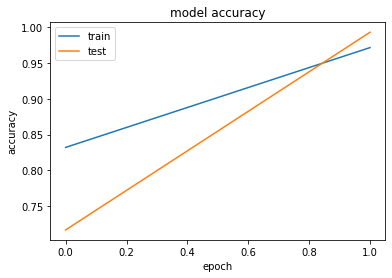

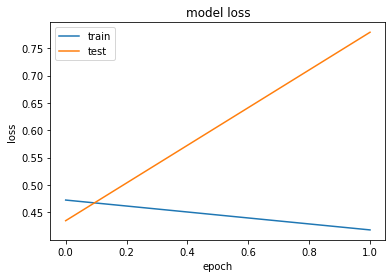

In [15]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()